In [9]:
#importing the required modules
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
import seaborn as sns

In [10]:
# Small adjustments to default style of plots, making sure it's readable and colorblind-friendly everywhere
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size' : 12.5,
                     'figure.figsize':(25,7)})

Get the path to retrieve data from local folder

In [11]:
#Jules: 
#Small sample
path = r'/Users/jules/kDrive/onedrive/Documents_Onedrive/EPFL/MA3/ADA/Project/Dataset/'

#Big sample
#path = r'C:\Users\jules\kDrive\onedrive\Documents_Onedrive\EPFL\MA3\ADA\Project\Dataset\BIG_SAMPLE'

#### Using the provided csv file to link qids with meaningful names for speakers metadata

In [12]:
df_lookup = pd.read_csv('wikidata_labels_descriptions_quotebank.csv.bz2',compression = 'bz2',index_col='QID')

## 1. Create a function to retrieve all americans politicians

In [13]:
#drop NaNs in occupation
def get_polUS(df_speakers):
    df_speakers.dropna(axis=0,inplace=True,subset=['occupation','nationality'])
    assert df_speakers['occupation'].isna().sum() == 0
    assert df_speakers['nationality'].isna().sum() == 0
    
    pol_cond = df_speakers['occupation'].apply(lambda x : any(item in 'Q82955' for item in x)) 
    us_cond = df_speakers['nationality'].apply(lambda x : any(item in 'Q30' for item in x)) #Q142 for french 

    df_polUS = df_speakers.loc[us_cond & pol_cond]

    return df_polUS


# 2. Aggretate quotes by each speaker

In [14]:
#Retrieve the dataset containing all speakers with the fraction of the colloquial language 
df_speakers =  pd.read_json(path+'Speakers_aggregation.json.bz2',compression = 'bz2',lines = True)

In [15]:
# Drop the column related to classifications task ()
#df_speakers.drop(['0','1','fraction'],axis=1,inplace=True)

In [17]:
#Retrieve only the americans politicians 
df_polUS_2 = get_polUS(df_speakers)
df_polUS_2

,label,qid_unique,0,1,quotes_number,fraction,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,candidacy,type,religion
0,Barack Obama,Q76,1008,359,1367,0.262619,"[Barack Hussein Obama II, Barack Obama II, Bar...",[+1961-08-04T00:00:00Z],[Q30],[Q6581097],1395141963,"[Q49085, Q6935055, Q12826303, Q6392846]",O000167,"[Q82955, Q40348, Q15958642, Q28532974, Q372436]",[Q29552],"[Q1765120, Q1540185]",Q76,"[Q3586671, Q45578, Q4226, Q4791768, Q17067714,...",item,"[Q23540, Q1062789, Q960252, Q426316]"
1,Bernie Sanders,Q359442,723,268,991,0.270434,[Bernard Sanders],[+1941-09-08T00:00:00Z],[Q30],[Q6581097],1392561607,[Q7325],S000033,"[Q82955, Q1930187, Q154549, Q1622272, Q36180, ...","[Q6542163, Q29552, Q327591, Q327591, Q29552]",[Q1765120],Q359442,None,item,[Q9268]
3,Hillary Clinton,Q6294,645,245,890,0.275281,"[Hillary Rodham Clinton, Hillary Rodham, Hilla...",[+1947-10-26T00:00:00Z],[Q30],[Q6581072],1393846565,None,C001041,"[Q82955, Q40348, Q193391, Q36180, Q18814623, Q...","[Q29552, Q29468]","[Q163727, Q1540185]",Q6294,"[Q699872, Q4791768]",item,[Q33203]
4,Andrew Cuomo,Q11673,476,182,658,0.276596,[Andrew Mark Cuomo],[+1957-12-06T00:00:00Z],[Q30],[Q6581097],1393197828,[Q974693],None,"[Q40348, Q82955]",[Q29552],[Q1540185],Q11673,"[Q22023432, Q65047185]",item,[Q1841]
6,Elizabeth Warren,Q434706,378,179,557,0.321364,"[Elizabeth Ann Warren, Senator Warren, Elisabe...",[+1949-06-22T00:00:00Z],[Q30],[Q6581072],1394365746,[Q49078],W000817,"[Q185351, Q82955, Q37226, Q1622272, Q40348, Q1...",[Q29552],"[Q163727, Q1540185]",Q434706,[Q28220813],item,[Q33203]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106506,Hans Zeiger,Q3127030,1,0,1,0.000000,None,[+1985-02-20T00:00:00Z],[Q30],[Q6581097],1392052490,None,None,"[Q82955, Q1930187]",[Q29468],None,Q3127030,None,item,None
106634,Juan Babauta,Q3187744,1,0,1,0.000000,"[Juan N. Babauta, Juan Nekai Babauta]",[+1953-09-07T00:00:00Z],[Q30],[Q6581097],1396092459,None,None,[Q82955],[Q29468],None,Q3187744,None,item,[Q1841]
106724,P. W. Singer,Q320696,1,0,1,0.000000,[Peter Warren Singer],[+1974-01-01T00:00:00Z],[Q30],[Q6581097],1393157459,None,None,"[Q1238570, Q82955]",None,[Q849697],Q320696,None,item,None
107202,George Ajjan,Q3101374,0,1,1,1.000000,None,[+1976-07-05T00:00:00Z],[Q30],[Q6581097],1392802317,None,None,[Q82955],[Q29468],None,Q3101374,None,item,None


### Create the age column

In [24]:
from datetime import date, datetime

def get_age(df):
    
    #Define the function to calculate the age of speakers 
    def calculate_age(born):
        today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

    date_format = '+%Y-%m-%dT%H:%M:%SZ'
    #Convert list into string
    df['date_of_birth'] = df['date_of_birth'].apply(lambda x: x[0] if x else None)
    
    #Retrieve date_of_birth with 00-00 as month/day and replace it by the 01-01
    df['date_of_birth']=df['date_of_birth'].apply(lambda x: x.replace('-00','-01') if x else None)

    #Transform date_of_birth from string to datetime
    df['date_of_birth'] = df['date_of_birth'].apply(lambda x: datetime.strptime(x,date_format)if x else None)
    
    # Calculate the age of each speakers
    df['age'] =  df['date_of_birth'].apply(lambda x: calculate_age(x) if x else None)
    
    return df

In [25]:
df_test_function = get_age(df_polUS_2)

NameError: name 'today' is not defined

In [163]:
format = '+%Y-%m-%dT%H:%M:%SZ'

In [164]:
#Convert list into string
df_polUS_2['date_of_birth'] = df_polUS_2['date_of_birth'].apply(lambda x: x[0] if x else None)
 

C:\Users\jules\AppData\Local\Temp/ipykernel_7596/2800902550.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_polUS_2['date_of_birth'] = df_polUS_2['date_of_birth'].apply(lambda x: x[0] if x else None)


In [165]:
#Retrieve date_of_birth with 00-00 as month/day and replace it by the 01-01
df_polUS_2['date_of_birth']=df_polUS_2['date_of_birth'].apply(lambda x: x.replace('-00','-01') if x else None)


C:\Users\jules\AppData\Local\Temp/ipykernel_7596/2836426092.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_polUS_2['date_of_birth']=df_polUS_2['date_of_birth'].apply(lambda x: x.replace('-00','-01') if x else None)


In [170]:
#df_polUS_2.drop_na(axis=0,inplace=True,subset=['date_of_birth'] )
df_polUS_2['date_of_birth'] = df_polUS_2['date_of_birth'].apply(lambda x: datetime.strptime(x,format)if x else None)

C:\Users\jules\AppData\Local\Temp/ipykernel_7596/2004508795.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_polUS_2['date_of_birth'] = df_polUS_2['date_of_birth'].apply(lambda x: datetime.strptime(x,format)if x else None)


In [162]:
from datetime import date, datetime

def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

In [171]:
# Convert date_of_birth into list[str] into a datetime 
df_polUS_2['age'] =  df_polUS_2['date_of_birth'].apply(lambda x: calculate_age(x) if x else None)

C:\Users\jules\AppData\Local\Temp/ipykernel_7596/3628144934.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_polUS_2['age'] =  df_polUS_2['date_of_birth'].apply(lambda x: calculate_age(x) if x else None)


In [173]:
df_polUS_2.head(5)

,label,qid_unique,0,1,quotes_number,fraction,aliases,date_of_birth,nationality,gender,...,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,candidacy,type,religion,age
0,Barack Obama,Q76,1008,359,1367,0.262619,"[Barack Hussein Obama II, Barack Obama II, Bar...",1961-08-04,[Q30],[Q6581097],...,"[Q49085, Q6935055, Q12826303, Q6392846]",O000167,"[Q82955, Q40348, Q15958642, Q28532974, Q372436]",[Q29552],"[Q1765120, Q1540185]",Q76,"[Q3586671, Q45578, Q4226, Q4791768, Q17067714,...",item,"[Q23540, Q1062789, Q960252, Q426316]",60.0
1,Bernie Sanders,Q359442,723,268,991,0.270434,[Bernard Sanders],1941-09-08,[Q30],[Q6581097],...,[Q7325],S000033,"[Q82955, Q1930187, Q154549, Q1622272, Q36180, ...","[Q6542163, Q29552, Q327591, Q327591, Q29552]",[Q1765120],Q359442,None,item,[Q9268],80.0
3,Hillary Clinton,Q6294,645,245,890,0.275281,"[Hillary Rodham Clinton, Hillary Rodham, Hilla...",1947-10-26,[Q30],[Q6581072],...,None,C001041,"[Q82955, Q40348, Q193391, Q36180, Q18814623, Q...","[Q29552, Q29468]","[Q163727, Q1540185]",Q6294,"[Q699872, Q4791768]",item,[Q33203],74.0
4,Andrew Cuomo,Q11673,476,182,658,0.276596,[Andrew Mark Cuomo],1957-12-06,[Q30],[Q6581097],...,[Q974693],None,"[Q40348, Q82955]",[Q29552],[Q1540185],Q11673,"[Q22023432, Q65047185]",item,[Q1841],63.0
6,Elizabeth Warren,Q434706,378,179,557,0.321364,"[Elizabeth Ann Warren, Senator Warren, Elisabe...",1949-06-22,[Q30],[Q6581072],...,[Q49078],W000817,"[Q185351, Q82955, Q37226, Q1622272, Q40348, Q1...",[Q29552],"[Q163727, Q1540185]",Q434706,[Q28220813],item,[Q33203],72.0


<AxesSubplot:>

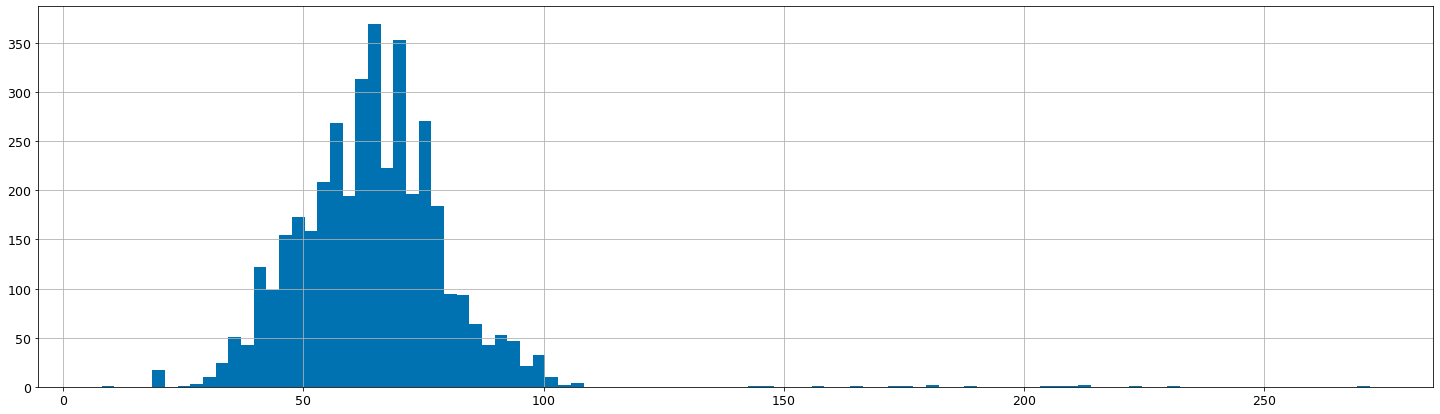

In [174]:
#Plot the distribution of ages 
df_polUS_2['age'].hist(bins=100)

In [187]:
#Detect ages that are incoherent and drop the rows 
#df_polUS_2[df_polUS_2['age']>100]
df_polUS_2.drop(df_polUS_2[df_polUS_2['age']<25].index, inplace=True)
df_polUS_2.drop(df_polUS_2[df_polUS_2['age']>100].index, inplace=True)


<AxesSubplot:>

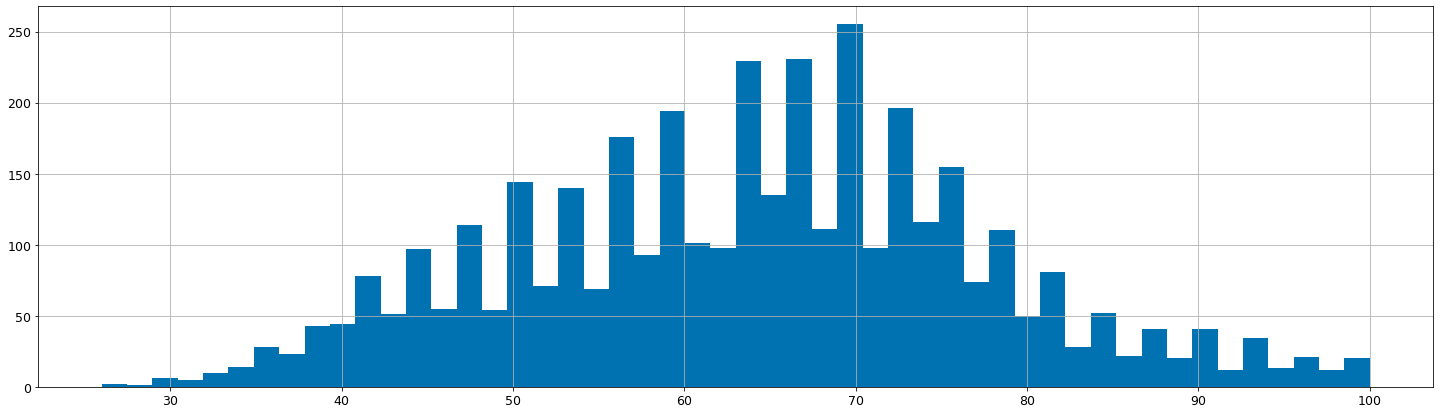

In [189]:
df_polUS_2['age'].hist(bins=50)

### Create a column containg either "Democrate" or "Republican" party

QID Republican : Q29468

QID Democratic Q29552

In [231]:
demo_cond = df_polUS_2['party'].apply(lambda x : any(item in 'Q29552' for item in x) if x else False)
repu_cond = df_polUS_2['party'].apply(lambda x : any(item in 'Q29468' for item in x) if x else False)


In [235]:
df_polUS_2['rep_demo']=None
df_polUS_2.head()

C:\Users\jules\AppData\Local\Temp/ipykernel_7596/775756068.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_polUS_2['rep_demo']=None


,label,qid_unique,0,1,quotes_number,fraction,aliases,date_of_birth,nationality,gender,...,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,candidacy,type,religion,rep_demo
0,Barack Obama,Q76,1008,359,1367,0.262619,"[Barack Hussein Obama II, Barack Obama II, Bar...",[+1961-08-04T00:00:00Z],[Q30],[Q6581097],...,"[Q49085, Q6935055, Q12826303, Q6392846]",O000167,"[Q82955, Q40348, Q15958642, Q28532974, Q372436]",[Q29552],"[Q1765120, Q1540185]",Q76,"[Q3586671, Q45578, Q4226, Q4791768, Q17067714,...",item,"[Q23540, Q1062789, Q960252, Q426316]",None
1,Bernie Sanders,Q359442,723,268,991,0.270434,[Bernard Sanders],[+1941-09-08T00:00:00Z],[Q30],[Q6581097],...,[Q7325],S000033,"[Q82955, Q1930187, Q154549, Q1622272, Q36180, ...","[Q6542163, Q29552, Q327591, Q327591, Q29552]",[Q1765120],Q359442,None,item,[Q9268],None
3,Hillary Clinton,Q6294,645,245,890,0.275281,"[Hillary Rodham Clinton, Hillary Rodham, Hilla...",[+1947-10-26T00:00:00Z],[Q30],[Q6581072],...,None,C001041,"[Q82955, Q40348, Q193391, Q36180, Q18814623, Q...","[Q29552, Q29468]","[Q163727, Q1540185]",Q6294,"[Q699872, Q4791768]",item,[Q33203],None
4,Andrew Cuomo,Q11673,476,182,658,0.276596,[Andrew Mark Cuomo],[+1957-12-06T00:00:00Z],[Q30],[Q6581097],...,[Q974693],None,"[Q40348, Q82955]",[Q29552],[Q1540185],Q11673,"[Q22023432, Q65047185]",item,[Q1841],None
6,Elizabeth Warren,Q434706,378,179,557,0.321364,"[Elizabeth Ann Warren, Senator Warren, Elisabe...",[+1949-06-22T00:00:00Z],[Q30],[Q6581072],...,[Q49078],W000817,"[Q185351, Q82955, Q37226, Q1622272, Q40348, Q1...",[Q29552],"[Q163727, Q1540185]",Q434706,[Q28220813],item,[Q33203],None


In [236]:
df_polUS_2.loc[demo_cond,'rep_demo'] = 'Democrat'
df_polUS_2.loc[repu_cond,'rep_demo'] = 'Republican'

df_polUS_2.head()

C:\Users\jules\anaconda3\envs\ada\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,label,qid_unique,0,1,quotes_number,fraction,aliases,date_of_birth,nationality,gender,...,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,candidacy,type,religion,rep_demo
0,Barack Obama,Q76,1008,359,1367,0.262619,"[Barack Hussein Obama II, Barack Obama II, Bar...",[+1961-08-04T00:00:00Z],[Q30],[Q6581097],...,"[Q49085, Q6935055, Q12826303, Q6392846]",O000167,"[Q82955, Q40348, Q15958642, Q28532974, Q372436]",[Q29552],"[Q1765120, Q1540185]",Q76,"[Q3586671, Q45578, Q4226, Q4791768, Q17067714,...",item,"[Q23540, Q1062789, Q960252, Q426316]",Democrat
1,Bernie Sanders,Q359442,723,268,991,0.270434,[Bernard Sanders],[+1941-09-08T00:00:00Z],[Q30],[Q6581097],...,[Q7325],S000033,"[Q82955, Q1930187, Q154549, Q1622272, Q36180, ...","[Q6542163, Q29552, Q327591, Q327591, Q29552]",[Q1765120],Q359442,None,item,[Q9268],Democrat
3,Hillary Clinton,Q6294,645,245,890,0.275281,"[Hillary Rodham Clinton, Hillary Rodham, Hilla...",[+1947-10-26T00:00:00Z],[Q30],[Q6581072],...,None,C001041,"[Q82955, Q40348, Q193391, Q36180, Q18814623, Q...","[Q29552, Q29468]","[Q163727, Q1540185]",Q6294,"[Q699872, Q4791768]",item,[Q33203],Republican
4,Andrew Cuomo,Q11673,476,182,658,0.276596,[Andrew Mark Cuomo],[+1957-12-06T00:00:00Z],[Q30],[Q6581097],...,[Q974693],None,"[Q40348, Q82955]",[Q29552],[Q1540185],Q11673,"[Q22023432, Q65047185]",item,[Q1841],Democrat
6,Elizabeth Warren,Q434706,378,179,557,0.321364,"[Elizabeth Ann Warren, Senator Warren, Elisabe...",[+1949-06-22T00:00:00Z],[Q30],[Q6581072],...,[Q49078],W000817,"[Q185351, Q82955, Q37226, Q1622272, Q40348, Q1...",[Q29552],"[Q163727, Q1540185]",Q434706,[Q28220813],item,[Q33203],Democrat


In [237]:
df_polUS_2[['label','party','rep_demo']]

,label,party,rep_demo
0,Barack Obama,[Q29552],Democrat
1,Bernie Sanders,"[Q6542163, Q29552, Q327591, Q327591, Q29552]",Democrat
3,Hillary Clinton,"[Q29552, Q29468]",Republican
4,Andrew Cuomo,[Q29552],Democrat
6,Elizabeth Warren,[Q29552],Democrat
...,...,...,...
106506,Hans Zeiger,[Q29468],Republican
106634,Juan Babauta,[Q29468],Republican
106724,P. W. Singer,None,None
107202,George Ajjan,[Q29468],Republican


### Plot the distribution of colloquial language speaker in political party

[Text(0, 0.5, 'Average fraction of colloquial quotations')]

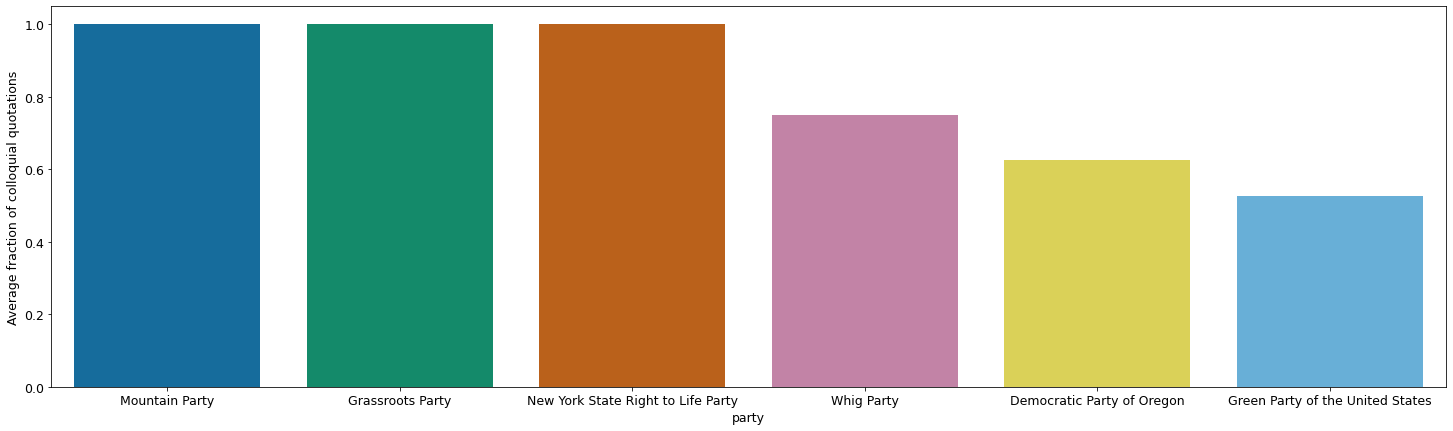

In [18]:

df_party=df_polUS_2.copy()
#Replace label column at the first place to see speakers names
df_party.dropna(axis = 0, subset=['party'], inplace=True)

#Drop all speakers that several parties
oneparty_cond = df_party['party'].apply(lambda x: len(x)==1)

#Transforma a list into one element
df_party['party'] = df_party['party'].apply(lambda x: x[0]) 

df_party = df_party[oneparty_cond]
#Not taking in account the occupation with fraction equals to 1 (correspond to speakers with not sufficient amount of quotations)
df_plot = df_party.groupby('party')['fraction'].mean() \
           .reset_index(name='mean_fraction')\
            .sort_values(['mean_fraction'], ascending=False)
#Not taking in account the occupation with fraction equals to 1 (correspond to speakers with not sufficient amount of quotations)

#df_plot = df_plot[df_plot['mean_fraction']!=1]
df_plot['party'] = df_plot['party'].apply(lambda x: df_lookup.loc[x]['Label'])

ax = sns.barplot(x='party', y="mean_fraction", data=df_plot[:6])
ax.set(ylabel='Average fraction of colloquial quotations')

In [19]:
print("There are {} parties in our dataset".format(len(df_plot)))

There are 62 parties in our dataset


# 3 Create the dataset for linear regression 

Keep only the quotes where the author is in df_us 

i. Import the quotes data 

In [20]:
#Small sample
df_quotes = pd.read_json(path+'Sample_classified_1Mio_v1.json.bz2',compression = 'bz2',lines = True)

#Big sample

In [21]:
df_quotes.head(10)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,p1,p2,delta_p,year,colloquial
0,2015-11-11-109291,They'll call me lots of different things. Libe...,Chris Christie,[Q63879],2015-11-11 00:55:12,1,"[[Chris Christie, 0.7395], [Bobby Jindal, 0.15...",[http://thehill.com/blogs/ballot-box/259760-ch...,E,0.7395,0.1505,0.5890,2015,0
1,2015-09-11-070666,It's kind of the same way it's been with the R...,Niklas Kronwall,[Q722939],2015-09-11 19:54:00,1,"[[Niklas Kronwall, 0.7119], [None, 0.2067], [H...",[http://redwings.nhl.com/club/news.htm?id=7787...,E,0.7119,0.2067,0.5052,2015,0
2,2015-11-09-033345,I had a chuckle: They were showing a video of ...,Kris Draper,[Q948695],2015-11-09 00:57:45,3,"[[Kris Draper, 0.8782], [None, 0.1043], [Serge...",[http://ca.rd.yahoo.com/sports/rss/nfl/SIG=13u...,E,0.8782,0.1043,0.7739,2015,1
3,2015-09-05-038628,New Zealand will go in with a lot of confidenc...,John Eales,[Q926351],2015-09-05 02:40:10,3,"[[John Eales, 0.7896], [None, 0.2006], [Toutai...",[http://www.stuff.co.nz/sport/rugby/all-blacks...,E,0.7896,0.2006,0.5890,2015,0
4,2015-02-11-042325,In his suicide note he even made a joke thanki...,Pat Buckley,"[Q19956564, Q23006312, Q7143252, Q7143253]",2015-02-11 09:59:09,1,"[[Pat Buckley, 0.8816], [None, 0.1184]]",[http://independent.ie/life/health-wellbeing/m...,E,0.8816,0.1184,0.7632,2015,1
5,2015-06-28-039933,We played there [ at Wigan ] together a few ti...,FRASER Fyvie,[Q1361441],2015-06-28 00:19:04,1,"[[FRASER Fyvie, 0.8274], [None, 0.1726]]",[http://scotsman.com/sport/football/spfl-lower...,E,0.8274,0.1726,0.6548,2015,0
6,2015-09-23-021511,evident that the wonderful service they provid...,Michael Gove,[Q333937],2015-09-23 06:39:00,1,"[[Michael Gove, 0.8083], [None, 0.1602], [Alis...",[http://www.getsurrey.co.uk/news/surrey-news/c...,E,0.8083,0.1602,0.6481,2015,0
7,2015-09-13-037558,Our challenge is to make the second series as ...,Ed Thomas,"[Q27863975, Q43572545, Q5335488]",2015-09-13 15:50:40,1,"[[Ed Thomas, 0.6648], [None, 0.2016], [Richard...",[http://www.huffingtonpost.co.uk/2015/09/13/hi...,E,0.6648,0.2016,0.4632,2015,0
8,2015-01-28-007463,At the National Churches Trust we help fund ur...,Claire Walker,[Q58452685],2015-01-28 12:15:00,3,"[[Claire Walker, 0.8704], [None, 0.1296]]",[http://www.businesswire.com/news/home/2015012...,E,0.8704,0.1296,0.7408,2015,1
9,2015-12-01-014937,But you did and I want to thank you. Great job...,Ellen Malcolm,[Q1563121],2015-12-01 18:14:57,1,"[[Ellen Malcolm, 0.6775], [Cheryl Mills, 0.165...",[http://www.politico.com/story/2015/12/hillary...,E,0.6775,0.1657,0.5118,2015,1


ii. Import the speakers metadata

In [22]:
#Define the path for folder containing data
#TO BE MODIFIED ACCORDING HIS OWN FOLER containing data in local 
#Jules:
path = r'/Users/jules/kDrive/onedrive/Documents_Onedrive/EPFL/MA3/ADA/Project/Dataset/'
df_metadata = pd.read_parquet(path+'speaker_attributes.parquet')
#df_metadata.head()

In [23]:
df_meta_polUS = get_polUS(df_metadata)

In [24]:
# shift column 'Name' to first position
first_column = df_meta_polUS.pop('label')
# insert column using insert(position,column_name,first_column) function
df_meta_polUS.insert(0, 'label', first_column)

iii. Make the column "qid_speaker" unique 

In [25]:
#Choose the first QID that is associated with (to be improved)
df_quotes['qid_unique'] = df_quotes['qids'].apply(lambda x: x[0])

#Drop the useless columns 
col_useless = ['qids','probas','numOccurrences','phase']
df_quotes.drop(col_useless,axis=1,inplace=True)

In [26]:
# shift column 'Name' to first position
first_column = df_quotes.pop('qid_unique')
# insert column using insert(position,column_name,first_column) function
df_quotes.insert(3, 'qid_unique', first_column)

In [27]:
df_quotes.loc[df_quotes['speaker']=='Donald Trump']

,quoteID,quotation,speaker,qid_unique,date,urls,p1,p2,delta_p,year,colloquial
387,2015-12-01-105669,the world is in turmoil and falling apart in s...,Donald Trump,Q22686,2015-12-01 16:58:57,[http://www.motherjones.com/blue-marble/2015/1...,0.7342,0.1509,0.5833,2015,0
391,2015-08-12-042086,I wonder if the Mexican government sent them h...,Donald Trump,Q22686,2015-08-12 22:25:37,[http://www.huffingtonpost.com/lawrence-rosent...,0.7393,0.2607,0.4786,2015,0
479,2015-08-12-040836,I wanted to see the states decide. And I wante...,Donald Trump,Q22686,2015-08-12 20:58:28,[http://breitbart.com/video/2015/08/12/trump-o...,0.9328,0.0672,0.8656,2015,0
2778,2015-09-26-026590,"I'm putting up my own funding,",Donald Trump,Q22686,2015-09-26 02:42:39,[http://oudaily.com/news/donald-trump-refuses-...,0.6651,0.3349,0.3302,2015,0
3062,2015-10-29-103496,That's what I can do for the country: We owe $...,Donald Trump,Q22686,2015-10-29 02:41:38,[http://thestreet.com/story/13343003/1/donald-...,0.7893,0.2107,0.5786,2015,0
...,...,...,...,...,...,...,...,...,...,...,...
665681,2020-01-08-039229,"In order to get elected, will start a war with...",Donald Trump,Q22686,2020-01-08 01:21:52,[http://journalreview.com/stories/trump-campai...,0.6791,0.2360,0.4431,2020,0
666854,2020-03-17-084961,"Well, I think the 3.4% [ COVID-19 death rate ]...",Donald Trump,Q22686,2020-03-17 03:30:04,[http://newshounds.us/outrageous_fox_quote_of_...,0.9110,0.0890,0.8220,2020,0
667007,2020-02-06-045994,If you believe that we should defend American ...,Donald Trump,Q22686,2020-02-06 07:48:20,[https://www.thehindubusinessline.com/news/wor...,0.8965,0.0977,0.7988,2020,0
667023,2020-01-03-047013,"Over the years, Iran and its proxies have bomb...",Donald Trump,Q22686,2020-01-03 23:09:21,[https://www.washingtonexaminer.com/news/from-...,0.8229,0.1600,0.6629,2020,1


iv. Merge the quotes with the speaker metadata

In [28]:
df_quotes_merged = df_quotes.merge(df_meta_polUS,how='inner',left_on='qid_unique', right_on='id')

In [29]:
df_quotes_merged.head()

,quoteID,quotation,speaker,qid_unique,date,urls,p1,p2,delta_p,year,...,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,candidacy,type,religion
0,2015-08-19-053089,"It's a rotten process, it's a defiled process,...",Evan Jenne,Q5415439,2015-08-19 22:03:58,[http://www.washingtontimes.com/news/2015/aug/...,0.8643,0.1327,0.7316,2015,...,1393420472,None,None,[Q82955],[Q29552],None,Q5415439,None,item,None
1,2015-06-19-007527,"By the very definition of the word, this proce...",Evan Jenne,Q5415439,2015-06-19 01:08:41,[http://www.news4jax.com/politics/in-final-hou...,0.8724,0.1276,0.7448,2015,...,1393420472,None,None,[Q82955],[Q29552],None,Q5415439,None,item,None
2,2015-08-15-072111,Why? If I was allowed to have both hands on th...,Evan Jenne,Q5415439,2015-08-15 16:21:15,[http://web.tampabay.com/news/politics/statero...,0.8298,0.1702,0.6596,2015,...,1393420472,None,None,[Q82955],[Q29552],None,Q5415439,None,item,None
3,2017-06-24-036281,It's not that hard of a reach to say this law ...,Evan Jenne,Q5415439,2017-06-24 10:30:23,[http://www2.tbo.com/news/florida/on-open-reco...,0.8540,0.1360,0.7180,2017,...,1393420472,None,None,[Q82955],[Q29552],None,Q5415439,None,item,None
4,2019-04-30-050786,"Is there a moat, a barge system?",Evan Jenne,Q5415439,2019-04-30 00:00:00,[http://floridapolitics.com/archives/295137-ho...,0.7546,0.2036,0.5510,2019,...,1393420472,None,None,[Q82955],[Q29552],None,Q5415439,None,item,None


### vi. Export the dataframe

In [30]:
df_quotes_merged.to_json(path+'polUS_quotes_speakers_merged.json.bz2',compression='bz2',lines=True,orient="records")